In this notebook, we will analyze stock data sourced from Alpha Vantage. Our workflow will include:

   1. Feature Engineering – Creating meaningful features from raw stock data to enhance our analysis and modeling.

   2. Data Visualization – Exploring trends, patterns, and relationships in the data through visualizations.

   3. Predictive Modeling – Building a model to forecast stock behavior using the engineered features.

By the end of this notebook, we aim to uncover insights from historical stock data and demonstrate a predictive approach that can inform trading or investment decisions.

In [2]:
# Load data into a pandas DataFrame
import pandas as pd
import matplotlib.dates as mdates

# Load the CSV file
file_path = 'daily_IBM.csv'
df = pd.read_csv(file_path)

# Rename the 'timestamp' column to 'date'
df = df.rename(columns={'timestamp': 'date'})

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

print(df)

         date    open      high       low   close    volume
0  2025-10-24  283.77  310.7500  282.2100  307.46  16914243
1  2025-10-23  264.95  285.5791  263.5623  285.00  16676394
2  2025-10-22  281.99  289.1700  281.3500  287.51  10538480
3  2025-10-21  283.31  285.3100  281.6000  282.05   4080981
4  2025-10-20  281.25  285.5000  280.9600  283.65   3494336
..        ...     ...       ...       ...     ...       ...
95 2025-06-10  273.19  277.4700  272.5600  276.24   5163507
96 2025-06-09  268.10  273.4700  266.7100  272.08   4331464
97 2025-06-06  267.99  270.1700  267.5300  268.87   2495543
98 2025-06-05  265.20  267.5100  265.1000  266.86   2659478
99 2025-06-04  264.90  267.0000  264.7900  265.52   2588741

[100 rows x 6 columns]


In [3]:
# Convert columns to float
df['open'] = df['open'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)

In [4]:
import numpy as np

df["day's range"] = df['close'] - df['open']
df['price difference'] = df['high'] - df['low']
df['day to day'] = df['close'] - df['open'].shift(1)
df['log returns'] = np.log(df['close'] / df['close'].shift(1))                       

In [5]:
# Overall range
overall_range = df['close'].max() - df['open'].min()
print("Overall Open-to-Close Range:", overall_range)

Overall Open-to-Close Range: 71.25999999999999


In [6]:
df.head(2)

,date,open,high,low,close,volume,day's range,price difference,day to day,log returns
0,2025-10-24,283.77,310.7500,282.2100,307.46,16914243.0,23.69,28.5400,NaN,NaN
1,2025-10-23,264.95,285.5791,263.5623,285.00,16676394.0,20.05,22.0168,1.23,-0.075856


In [7]:
# Sort by date just in case
df = df.sort_values('date')

# Day-to-day volume change
df['volume_change'] = df['volume'] - df['volume'].shift(1)

# Optional: percentage change
df['volume_pct_change'] = df['volume'].pct_change() * 100

# Calculate Price / Volume for each row (using Close price)
df['price by volume'] = df['close'] / df['volume']

In [8]:
# Initialize OBV
df['obv'] = 0

# Loop method with .loc
for i in range(1, len(df)):
    if df['close'].iloc[i] > df['close'].iloc[i-1]:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv'] + df.loc[i, 'volume']
    elif df['close'].iloc[i] < df['close'].iloc[i-1]:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv'] - df.loc[i, 'volume']
    else:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv']

# 7-day moving average of volume
df['volume_ma7'] = df['volume'].rolling(window=7).mean()

In [9]:
df.head(2)

,date,open,high,low,close,volume,day's range,price difference,day to day,log returns,volume_change,volume_pct_change,price by volume,obv,volume_ma7
99,2025-06-04,264.9,267.00,264.79,265.52,2588741.0,0.62,2.21,0.32,-0.005034,NaN,NaN,0.000103,108563896,NaN
98,2025-06-05,265.2,267.51,265.10,266.86,2659478.0,1.66,2.41,-1.13,-0.007504,70737.0,2.732487,0.000100,105975155,NaN


In [10]:
# Create lag features for close and volume
lag_days = [1, 2, 3]  # 1-day, 2-day, 3-day lags

for lag in lag_days:
    df[f'close_lag_{lag}'] = df['close'].shift(lag)
    df[f'volume_lag_{lag}'] = df['volume'].shift(lag)
    df[f'price_by_volume_lag_{lag}'] = (df['close'] * df['volume']).shift(lag)

# View result
print(df[['date', 'close', 'close_lag_1', 'close_lag_2', 'close_lag_3',
          'volume', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3']])

         date   close  close_lag_1  close_lag_2  close_lag_3      volume  \
99 2025-06-04  265.52          NaN          NaN          NaN   2588741.0   
98 2025-06-05  266.86       265.52          NaN          NaN   2659478.0   
97 2025-06-06  268.87       266.86       265.52          NaN   2495543.0   
96 2025-06-09  272.08       268.87       266.86       265.52   4331464.0   
95 2025-06-10  276.24       272.08       268.87       266.86   5163507.0   
..        ...     ...          ...          ...          ...         ...   
4  2025-10-20  283.65       281.28       275.97       280.75   3494336.0   
3  2025-10-21  282.05       283.65       281.28       275.97   4080981.0   
2  2025-10-22  287.51       282.05       283.65       281.28  10538480.0   
1  2025-10-23  285.00       287.51       282.05       283.65  16676394.0   
0  2025-10-24  307.46       285.00       287.51       282.05  16914243.0   

    volume_lag_1  volume_lag_2  volume_lag_3  
99           NaN           NaN          

                      close    volume  price by volume  log returns  \
close              1.000000  0.027692         0.233067     0.054327   
volume             0.027692  1.000000        -0.783538    -0.091657   
price by volume    0.233067 -0.783538         1.000000    -0.025793   
log returns        0.054327 -0.091657        -0.025793     1.000000   
day to day         0.096541  0.241921        -0.225571     0.445545   
volume_change      0.054493  0.549529        -0.347982    -0.007438   
volume_pct_change  0.079389  0.552249        -0.498549     0.010295   
obv                0.629323 -0.231383         0.437138     0.039610   

                   day to day  volume_change  volume_pct_change       obv  
close                0.096541       0.054493           0.079389  0.629323  
volume               0.241921       0.549529           0.552249 -0.231383  
price by volume     -0.225571      -0.347982          -0.498549  0.437138  
log returns          0.445545      -0.007438           0

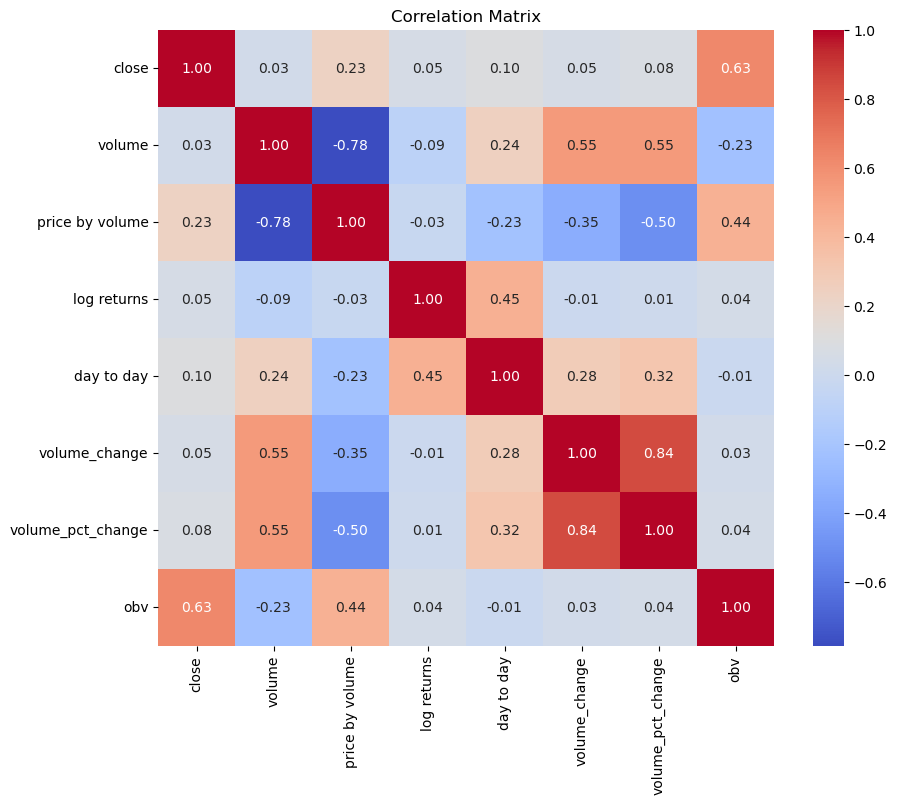

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns you want to check correlations for
numeric_cols = ['close', 'volume', 'price by volume', 'log returns', 
                'day to day', 'volume_change', 'volume_pct_change', 'obv']

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Display correlation matrix
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

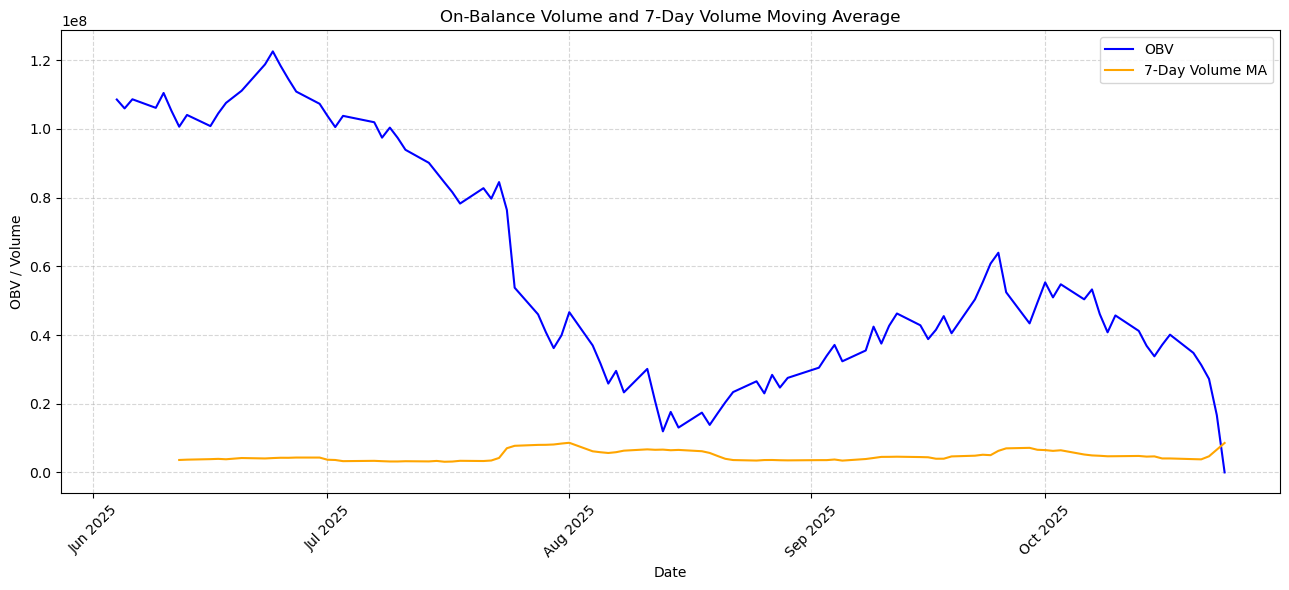

In [12]:
plt.figure(figsize=(13,6))

# OBV line
plt.plot(df['date'], df['obv'], color='blue', label='OBV')

# Volume moving average line
plt.plot(df['date'], df['volume_ma7'], color='orange', label='7-Day Volume MA')

# Format x-axis to show months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())       # one tick per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as "Jan 2025", etc.

plt.xlabel('Date')
plt.ylabel('OBV / Volume')
plt.title('On-Balance Volume and 7-Day Volume Moving Average')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

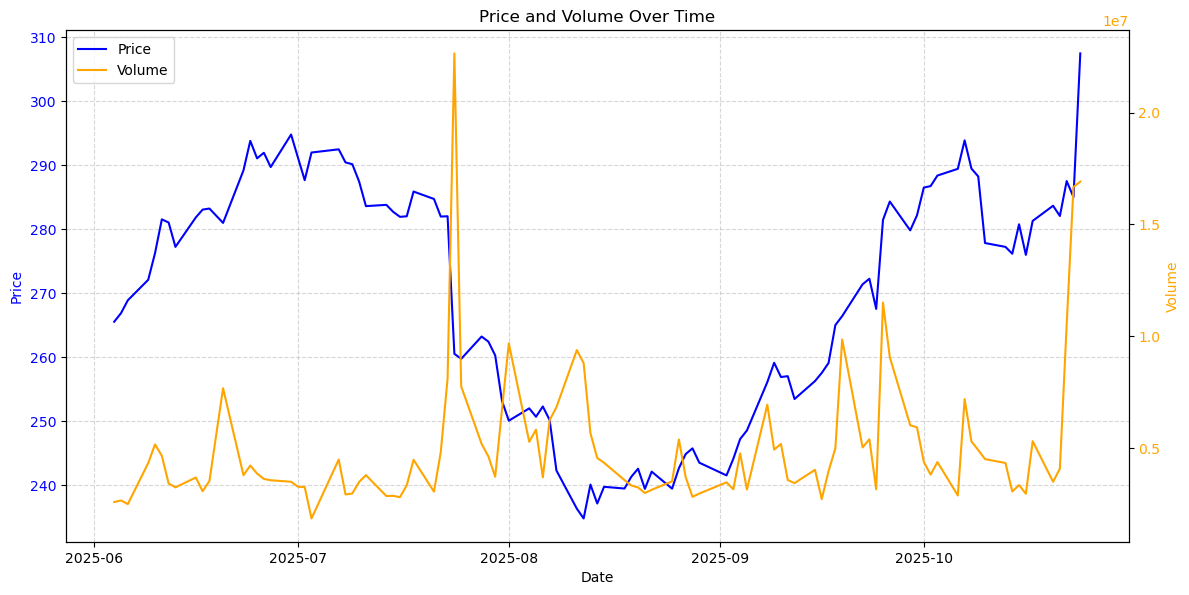

In [13]:
df['date'] = pd.to_datetime(df['date'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot price on left Y-axis
ax1.plot(df['date'], df['close'], color='blue', label='Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# Create second Y-axis for volume
ax2 = ax1.twinx()
ax2.plot(df['date'], df['volume'], color='orange', label='Volume')
ax2.set_ylabel('Volume', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend
fig.tight_layout()
plt.title('Price and Volume Over Time')

# Show combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

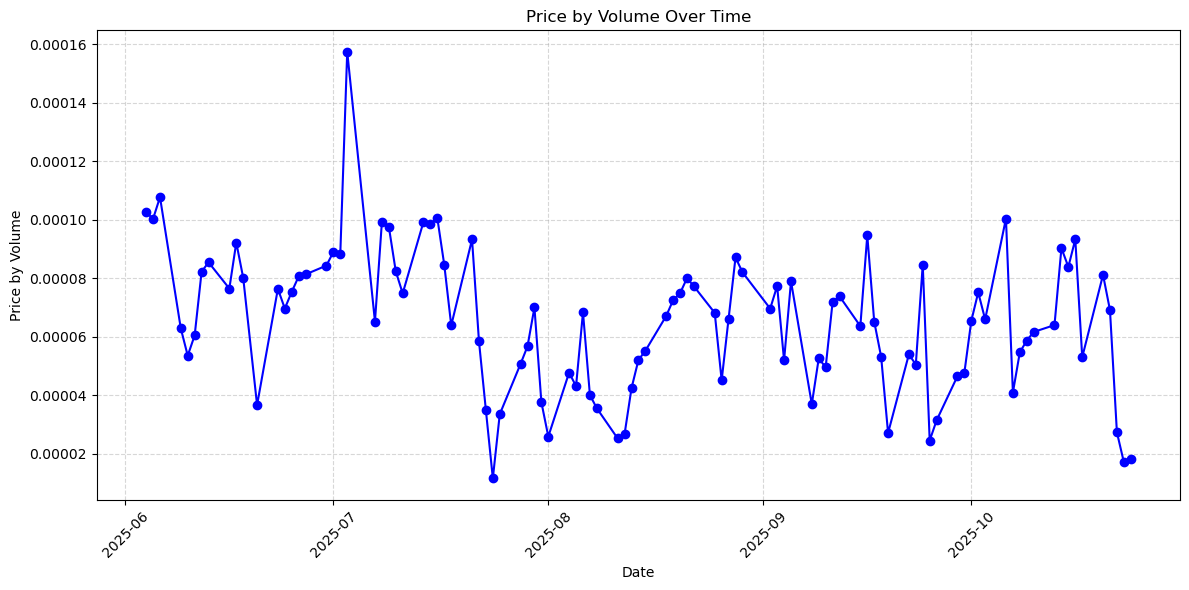

In [14]:
# Plot line graph
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Price by Volume')
plt.title('Price by Volume Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

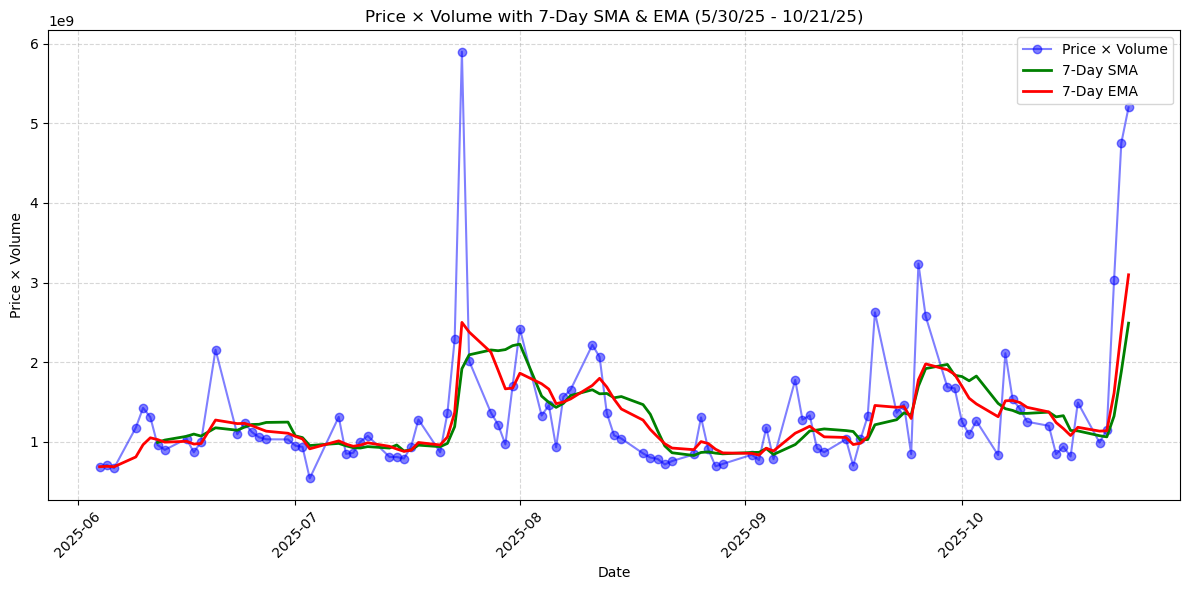

In [15]:
# Calculate Price × Volume
df['price by volume'] = df['close'] * df['volume']

# Calculate 7-day SMA
df['sma7'] = df['price by volume'].rolling(window=7).mean()

# Calculate 7-day EMA
df['ema7'] = df['price by volume'].ewm(span=7, adjust=False).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], marker='o', linestyle='-', alpha=0.5, label='Price × Volume', color='blue')
plt.plot(df['date'], df['sma7'], color='green', linewidth=2, label='7-Day SMA')
plt.plot(df['date'], df['ema7'], color='red', linewidth=2, label='7-Day EMA')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Price × Volume with 7-Day SMA & EMA (5/30/25 - 10/21/25)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Bullish SMA crossovers:
          date          sma7         sma30
66 2025-07-23  1.190962e+09  1.097380e+09
29 2025-09-15  1.141536e+09  1.128986e+09
25 2025-09-19  1.214257e+09  1.142080e+09
1  2025-10-23  1.882000e+09  1.547050e+09
Bearish SMA crossovers:
          date          sma7         sma30
48 2025-08-18  1.467663e+09  1.469580e+09
27 2025-09-17  1.023056e+09  1.093652e+09
10 2025-10-10  1.357720e+09  1.359623e+09
Bullish EMA crossovers:
          date          ema7         ema30
98 2025-06-05  6.929490e+08  6.888042e+08
96 2025-06-09  8.102181e+08  7.193218e+08
78 2025-07-07  1.012487e+09  9.726810e+08
74 2025-07-11  9.879795e+08  9.683579e+08
69 2025-07-18  9.916855e+08  9.606396e+08
33 2025-09-09  1.150819e+09  1.149755e+09
25 2025-09-19  1.456930e+09  1.203563e+09
13 2025-10-07  1.515022e+09  1.416093e+09
2  2025-10-22  1.611658e+09  1.396922e+09
Bearish EMA crossovers:
          date          ema7         ema30
97 2025-06-06  6.874559e+08  6.876540e+08
79 2025-07-03  9.1

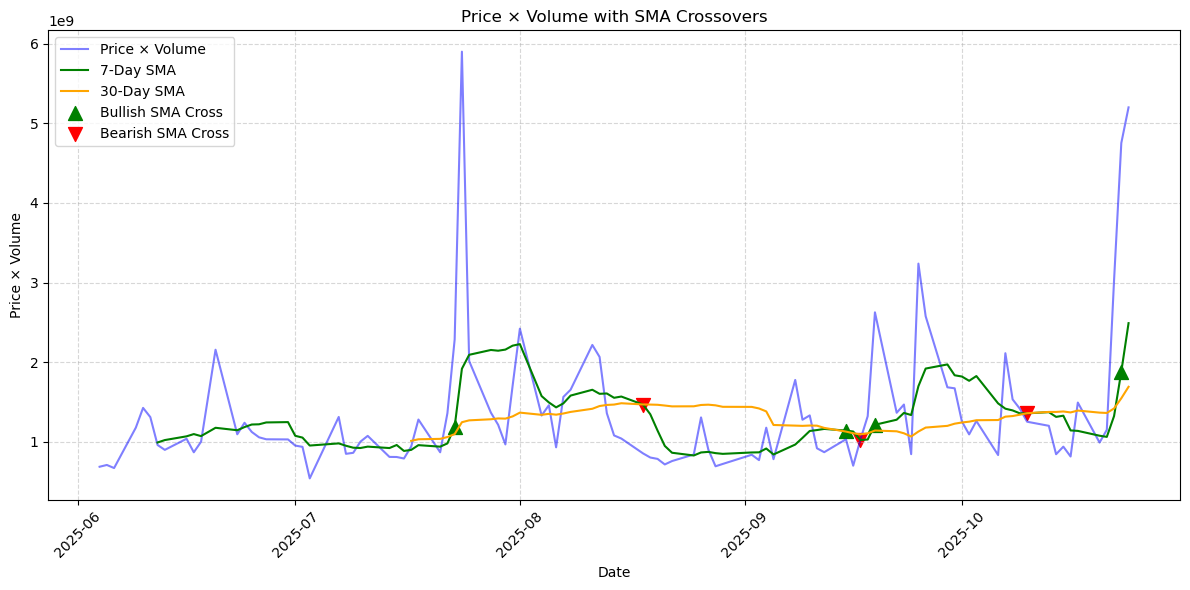

In [16]:
# Short-term and long-term SMAs
df['sma30'] = df['price by volume'].rolling(window=30).mean()

# Short-term and long-term EMAs
df['ema30'] = df['price by volume'].ewm(span=30, adjust=False).mean()

# Find crossover signals (SMA example)
df['sma_signal'] = np.where(df['sma7'] > df['sma30'], 1, 0)  # 1 = bullish, 0 = bearish
df['sma_crossover'] = df['sma_signal'].diff()  # 1 = buy, -1 = sell

# Find crossover signals (EMA example)
df['ema_signal'] = np.where(df['ema7'] > df['ema30'], 1, 0)
df['ema_crossover'] = df['ema_signal'].diff()

# Print crossover points
bullish_sma = df[df['sma_crossover'] == 1]
bearish_sma = df[df['sma_crossover'] == -1]

bullish_ema = df[df['ema_crossover'] == 1]
bearish_ema = df[df['ema_crossover'] == -1]

print("Bullish SMA crossovers:\n", bullish_sma[['date', 'sma7', 'sma30']])
print("Bearish SMA crossovers:\n", bearish_sma[['date', 'sma7', 'sma30']])
print("Bullish EMA crossovers:\n", bullish_ema[['date', 'ema7', 'ema30']])
print("Bearish EMA crossovers:\n", bearish_ema[['date', 'ema7', 'ema30']])

# Optional: plot SMA crossovers
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], color='blue', alpha=0.5, label='Price × Volume')
plt.plot(df['date'], df['sma7'], color='green', label='7-Day SMA')
plt.plot(df['date'], df['sma30'], color='orange', label='30-Day SMA')

# Mark bullish and bearish crossovers
plt.scatter(bullish_sma['date'], bullish_sma['sma7'], marker='^', color='g', s=100, label='Bullish SMA Cross')
plt.scatter(bearish_sma['date'], bearish_sma['sma7'], marker='v', color='r', s=100, label='Bearish SMA Cross')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Price × Volume with SMA Crossovers')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

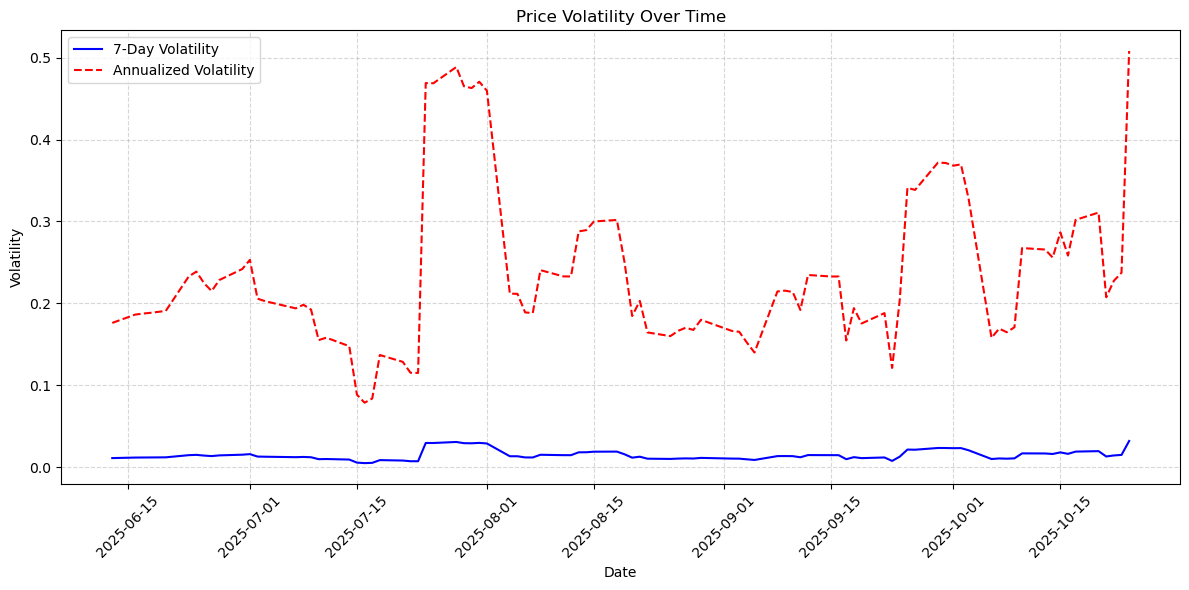

In [17]:
# Calculate daily returns
df['returns'] = df['close'].pct_change()

# Calculate rolling volatility (e.g., 7-day)
df['volatility_7d'] = df['returns'].rolling(window=7).std()

# Optional: annualized volatility (assuming 252 trading days)
df['volatility_annualized'] = df['volatility_7d'] * np.sqrt(252)

# Plot rolling volatility
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['volatility_7d'], label='7-Day Volatility', color='blue')
plt.plot(df['date'], df['volatility_annualized'], label='Annualized Volatility', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Price Volatility Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

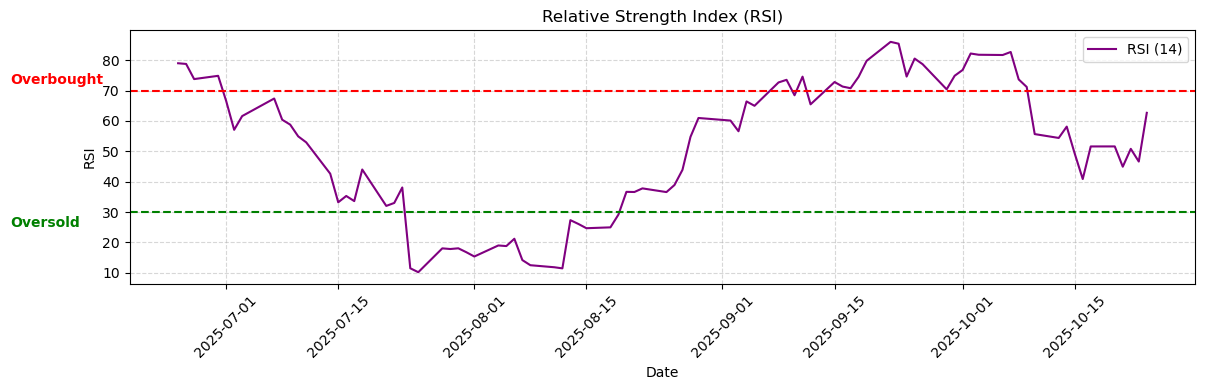

In [18]:
# Calculate daily returns
delta = df['close'].diff()

# Separate gains and losses
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

# Calculate average gain/loss
window = 14
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate RS and RSI
rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

# Plot RSI
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['rsi'], color='purple', label='RSI (14)')
plt.axhline(70, color='red', linestyle='--')  # overbought
plt.axhline(30, color='green', linestyle='--')  # oversold
plt.text(df['date'].iloc[0], 70+2, 'Overbought', color='red', fontsize=10, fontweight='bold')
plt.text(df['date'].iloc[0], 30-5, 'Oversold', color='green', fontsize=10, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('Relative Strength Index (RSI)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

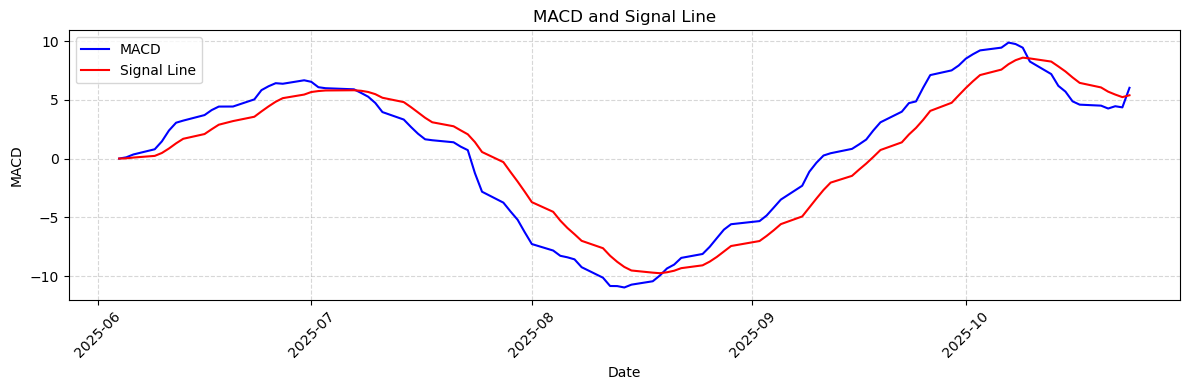

In [19]:
# Calculate MACD
ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26

# Signal line
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Plot MACD
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['macd'], label='MACD', color='blue')
plt.plot(df['date'], df['macd_signal'], label='Signal Line', color='red')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.title('MACD and Signal Line')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Create day of week column (0=Monday, 6=Sunday)
df['day_of_week'] = df['date'].dt.dayofweek

# Create day-of-week one-hot
df = pd.concat([df, pd.get_dummies(df['day_of_week'], prefix='dow')], axis=1)

# Check which columns exist
print(df.filter(like='dow_').columns)

Index(['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4'], dtype='object')


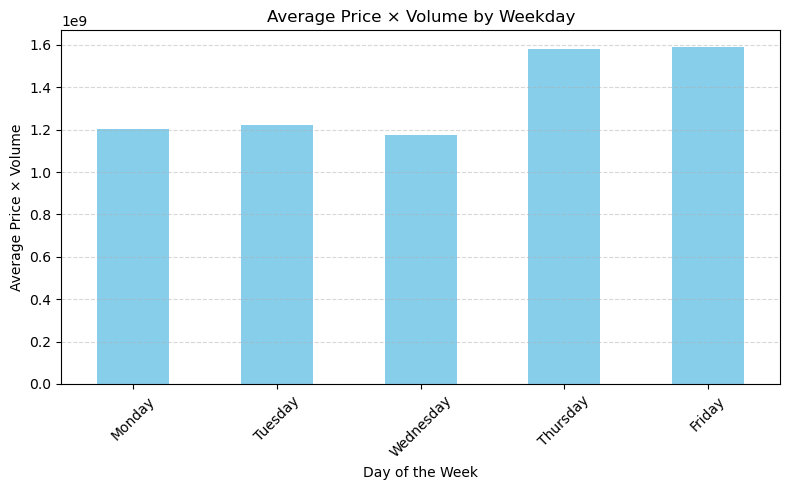

In [21]:
# Group by day_of_week and calculate average Price × Volume
avg_price_by_volume = df.groupby('day_of_week')['price by volume'].mean()

# Map day numbers to weekday names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
avg_price_by_volume.index = avg_price_by_volume.index.map(weekday_names)

# Plot
plt.figure(figsize=(8,5))
avg_price_by_volume.plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Price × Volume')
plt.title('Average Price × Volume by Weekday')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

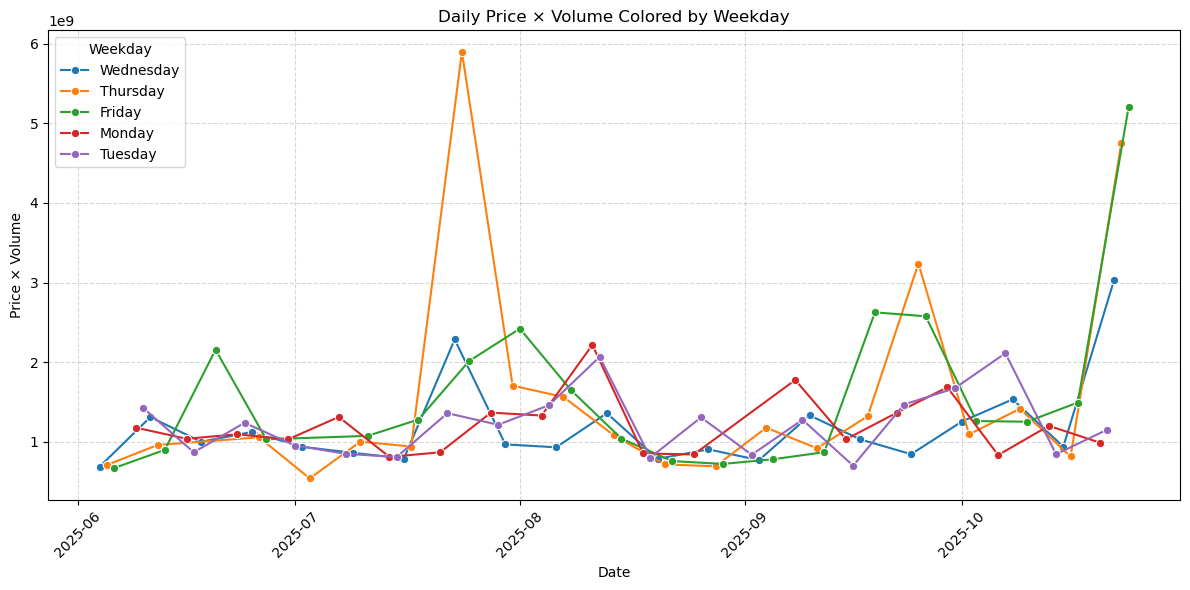

In [22]:
# Map numeric day_of_week to names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
df['weekday_name'] = df['day_of_week'].map(weekday_names)

# Set a color palette for weekdays
palette = sns.color_palette("tab10", n_colors=5)  # 5 weekdays

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='date', y='price by volume', hue='weekday_name', palette=palette, marker='o')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Daily Price × Volume Colored by Weekday')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Weekday')
plt.tight_layout()
plt.show()

In [23]:
#Average of close, volume by day of week
df.groupby('day_of_week')[['close', 'volume', 'price by volume']].mean()

,close,volume,price by volume
day_of_week,,,
0,270.684211,4.492894e+06,1.201652e+09
1,269.786000,4.553761e+06,1.221132e+09
2,270.230000,4.325389e+06,1.175469e+09
3,268.691500,5.879067e+06,1.580376e+09
4,268.558500,5.828755e+06,1.589588e+09


In [24]:
#Volatility by day of week
df.groupby('day_of_week')['log returns'].std()

day_of_week
0    0.009270
1    0.012137
2    0.023693
3    0.022962
4    0.014507
Name: log returns, dtype: float64

In [25]:
#Average daily return by day of week
df.groupby('day_of_week')['day to day'].mean()

day_of_week
0   -0.639474
1   -0.386750
2    2.034048
3    0.088000
4   -0.365263
Name: day to day, dtype: float64

In [26]:
#Which days have unusually high trading activity
threshold = df['volume'].mean() + df['volume'].std()
df[df['volume'] > threshold].groupby('day_of_week').size()

day_of_week
0    1
1    1
2    1
3    3
4    4
dtype: int64

In [27]:
#Correlation of pbv and daily by day of week
df.groupby('day_of_week')[['price by volume','day to day']].corr().iloc[0::2,-1]

day_of_week                 
0            price by volume    0.165798
1            price by volume   -0.002537
2            price by volume    0.886366
3            price by volume    0.285266
4            price by volume   -0.334756
Name: day to day, dtype: float64

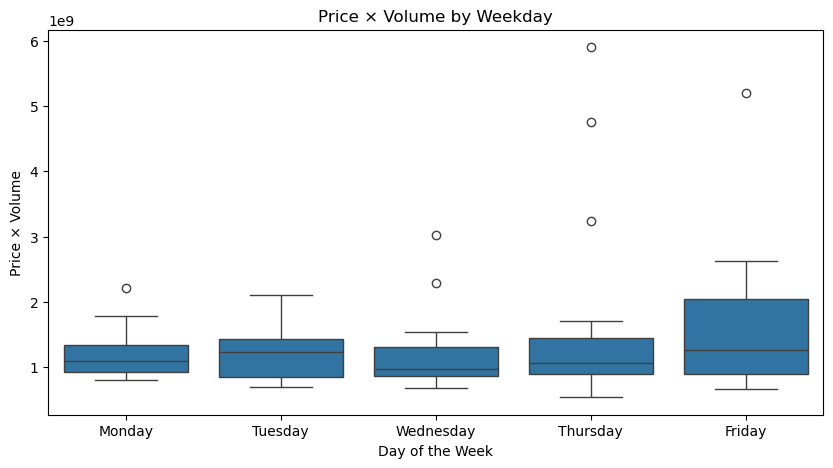

In [28]:
import seaborn as sns

# Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Boxplot with correct weekday order
plt.figure(figsize=(10,5))
sns.boxplot(x='weekday_name', y='price by volume', data=df, order=weekday_order)
plt.xlabel('Day of the Week')
plt.ylabel('Price × Volume')
plt.title('Price × Volume by Weekday')
plt.show()

In [29]:
# Overall skewness
print("Skewness of Price × Volume:", df['price by volume'].skew())
if df['price by volume'].skew() > 0:
    print('Skewed Right')
if df['price by volume'].skew() < 0:
    print('Skewed Left')
if df['price by volume'].skew() == 0:
    print('Roughly Symmetric')
print("Skewness of Volume:", df['volume'].skew())
if df['volume'].skew() > 0:
    print('Skewed Right')
if df['volume'].skew() < 0:
    print('Skewed Left')
if df['volume'].skew() == 0:
    print('Roughly Symmetric')
print("Skewness of Close:", df['close'].skew())
if df['close'].skew() > 0:
    print('Skewed Right')
if df['close'].skew() < 0:
    print('Skewed Left')
if df['close'].skew() == 0:
    print('Roughly Symmetric')

Skewness of Price × Volume: 3.1917327197449357
Skewed Right
Skewness of Volume: 3.1513336919616424
Skewed Right
Skewness of Close: -0.3429637841840928
Skewed Left


In [30]:
# Skewness of Price × Volume by day of week
skew_by_day = df.groupby('day_of_week')['price by volume'].skew()

# Map numeric day to names for readability
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
skew_by_day.index = skew_by_day.index.map(weekday_names)

# Interpret skewness for each day
for day, skew in skew_by_day.items():
    if skew > 0:
        interpretation = 'Skewed Right: Investors should be aware of potential for extreme gains'
    elif skew < 0:
        interpretation = 'Skewed Left: Could indicate risk of sharp losses or market inactivity'
    else:
        interpretation = 'Roughly Symmetric: Daily price changes or trading volume are more predictable'
    print(f"{day}: {skew:.2f} → {interpretation}")

# Print the skew values as well
print("\nSkewness values by day:")
print(skew_by_day)

Monday: 1.35 → Skewed Right: Investors should be aware of potential for extreme gains
Tuesday: 0.81 → Skewed Right: Investors should be aware of potential for extreme gains
Wednesday: 2.39 → Skewed Right: Investors should be aware of potential for extreme gains
Thursday: 2.31 → Skewed Right: Investors should be aware of potential for extreme gains
Friday: 2.26 → Skewed Right: Investors should be aware of potential for extreme gains

Skewness values by day:
day_of_week
Monday       1.348804
Tuesday      0.813238
Wednesday    2.394679
Thursday     2.314708
Friday       2.256278
Name: price by volume, dtype: float64


In [31]:
from sklearn.preprocessing import MinMaxScaler

# Drop rows with NaNs in essential columns
df = df.dropna(subset=['open', 'high', 'low', 'close', 'volume'])

# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale only the OHLCV columns (exclude 'date')
scaled_features = scaler.fit_transform(df[['open', 'high', 'low', 'close', 'volume']])

# Create a new DataFrame with scaled features
scaled_df = pd.DataFrame(scaled_features, columns=['open', 'high', 'low', 'close', 'volume'])

# Add the date column back
scaled_df['date'] = df['date'].values

# Preview
print(scaled_df.head())

       open      high       low     close    volume       date
0  0.483572  0.398956  0.524489  0.423029  0.035368 2025-06-04
1  0.488627  0.405962  0.529662  0.441464  0.038769 2025-06-05
2  0.535636  0.442506  0.570213  0.469115  0.030886 2025-06-06
3  0.537489  0.487842  0.556529  0.513276  0.119175 2025-06-09
4  0.623252  0.542794  0.654151  0.570505  0.159188 2025-06-10


In [32]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Prepare data
# Features: OHLCV
features = ['open','high','low','close','volume']
# Set the sequence length
seq_length = 10

# Extract values and dates
X_data = scaled_df[features].values.astype(np.float32)
if 'date' in scaled_df.columns:
    dates = scaled_df['date'].values
else:
    dates = scaled_df.index.values

In [33]:
from sklearn.model_selection import train_test_split

# Convert the scaled DataFrame to a numpy array
data_values = scaled_df[['open', 'high', 'low', 'close', 'volume']].values

# Also get the dates as a separate array
dates = scaled_df['date'].values

# Define a function to create sequences of data for LSTM
def create_sequences(data_array, seq_length, date_array):
    xs, ys = [], []
    y_dates = []
    for i in range(len(data_array) - seq_length):
        x_seq = data_array[i: i + seq_length]
        y_val = data_array[i + seq_length][3]  # index 3 => 'close' column
        xs.append(x_seq)
        ys.append(y_val)
        # The date that corresponds to this y_val
        y_dates.append(date_array[i + seq_length])
    return np.array(xs), np.array(ys), np.array(y_dates)


# Set the sequence length
seq_length = 10

# Create sequences (features, targets, and corresponding dates)
X, y, y_dates = create_sequences(data_values, seq_length, dates)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, y_dates_train, y_dates_test = train_test_split(
    X, y, y_dates, test_size=0.2
)

#Need to set up so that the training set is from the dates that are given. If there are 90 sequences, 0 to 72 need to be the training set.
#73 to 90 need to be the testing set

# Number of training sequences
split = len(X_train)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Print the shapes of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_dates_train length: {len(y_dates_train)}")
print(f"y_dates_test length: {len(y_dates_test)}")

X_train shape: torch.Size([72, 10, 5])
X_test shape: torch.Size([18, 10, 5])
y_train shape: torch.Size([72])
y_test shape: torch.Size([18])
y_dates_train length: 72
y_dates_test length: 18


In [34]:
#Build LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=128, output_size=1, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last time step
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")  # use Apple GPU
    elif torch.cuda.is_available():
        return torch.device("cuda")  # Nvidia GPU
    else:
        return torch.device("cpu")   # fallback to CPU

In [35]:
import torch.optim as optim

# Set the parameters
input_size = 5  # Number of features
hidden_layer_size = 50
output_size = 1
learning_rate = 0.001
num_epochs = 100

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_layer_size, output_size)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Get the device
device = get_device()

# Move model and data to device
model = model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i in range(len(X_train)):
        seq = X_train[i].unsqueeze(0).to(device)   # add batch dim
        label = y_train[i].unsqueeze(0).to(device)

        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {epoch_loss/len(X_train):.6f}")

# Save the trained model
torch.save(model.state_dict(), 'lstm_model.pth')

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.138007
Epoch 10 Loss: 0.011625
Epoch 20 Loss: 0.009386
Epoch 30 Loss: 0.008828
Epoch 40 Loss: 0.006881
Epoch 50 Loss: 0.008003
Epoch 60 Loss: 0.007240
Epoch 70 Loss: 0.006690
Epoch 80 Loss: 0.006841
Epoch 90 Loss: 0.004604


In [36]:
#Full data prediction
model.eval()
full_preds = []

# Start with the first sequence
current_seq = torch.tensor(X_data[:seq_length], dtype=torch.float32).unsqueeze(0).to(device)

for i in range(seq_length, len(X_data)):
    with torch.no_grad():
        pred = model(current_seq)
        full_preds.append(pred.item())
    # Prepare next sequence: drop first row, add next row
    next_row = torch.tensor(X_data[i], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    current_seq = torch.cat([current_seq[:,1:,:], next_row], dim=1)

#Inverse transform
# Recreate a scaler fitted on original raw data
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(df[features])

pred_array = np.zeros((len(full_preds), 5))
pred_array[:, 3] = full_preds
predicted_prices = scaler.inverse_transform(pred_array)[:, 3]

true_prices = df['close'].values[seq_length:]
dates_seq = dates[seq_length:]

PyTorch LSTM Test Metrics:
MSE: 7.3348
RMSE: 2.7083
MAE: 2.1406


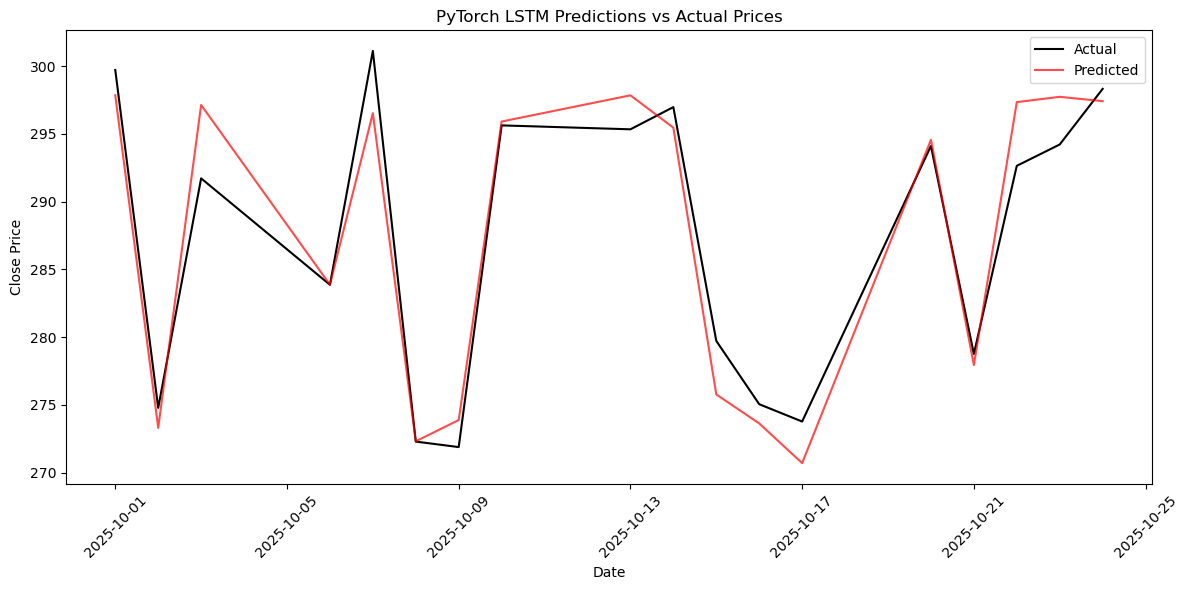

In [37]:
# ------------------------------
# Make predictions on the test set
# ------------------------------
model.eval()
test_predictions = []

for i in range(len(X_test)):
    seq = X_test[i].unsqueeze(0).to(device)  # add batch dim
    with torch.no_grad():
        test_predictions.append(model(seq).item())

test_predictions = np.array(test_predictions)
y_test_np = y_test.cpu().numpy()

# ------------------------------
# Invert scaling to get actual prices
# ------------------------------
close_idx = 3  # 'close' column index

# Predictions
test_preds_reshaped = np.zeros((len(test_predictions), len(features)))
test_preds_reshaped[:, close_idx] = test_predictions
test_predictions_inverted = scaler.inverse_transform(test_preds_reshaped)[:, close_idx]

# True values
y_test_reshaped = np.zeros((len(y_test_np), len(features)))
y_test_reshaped[:, close_idx] = y_test_np
y_test_inverted = scaler.inverse_transform(y_test_reshaped)[:, close_idx]

# ------------------------------
# Align dates
# ------------------------------
dates_test_plot = dates[seq_length + split : seq_length + split + len(test_predictions_inverted)]

# Mean Squared Error
mse = mean_squared_error(y_test_inverted, test_predictions_inverted)
# Root Mean Squared Error
rmse = np.sqrt(mse)
# Mean Absolute Error
mae = mean_absolute_error(y_test_inverted, test_predictions_inverted)

print("PyTorch LSTM Test Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot(dates_test_plot, y_test_inverted, label='Actual', color='black')
plt.plot(dates_test_plot, test_predictions_inverted, label='Predicted', color='red', alpha=0.7)
plt.title('PyTorch LSTM Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()